# 04. Pytorch Custom Datasets video notebook
We've used some datasets with pytorch before

But how do we get our own data into pytorch?

One of the way to do is via: custom datasets.

## Domain libraries

Depending on what we are working on vision, text, video, audio, etc we'll want to look  into each of the pytorch domain libraries for existing data loading functions and customizatble data loading functions.


### 0. Importing Pytorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

device= "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### 1. Get data
Our dataset is subset of Food101 dataset.

Food101 starts with 101 different classes of food and only 10% images of the images( ~75 training, 25 testing)

Our dataset starts with 3 classes of food and only 10% of the images (~75 training,25 testing).

Why do this?

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary.

The whole point is to speed up how fast we can experiment

In [2]:
import requests
import zipfile
from pathlib import Path

data_path= Path("data/")
image_path= data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} dir already exists")
else:
  print(f"Creating dir {image_path}")
  image_path.mkdir(parents=True, exist_ok=True)

# download the date now
with open(data_path/ "pizza_stake_sushi.zip", "wb") as f:
  request= requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data")
  f.write(request.content)

# unzip the data
with zipfile.ZipFile(data_path/ "pizza_stake_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak, sushi data")
  zip_ref.extractall(image_path)


Creating dir data/pizza_steak_sushi
Unzipping pizza, steak, sushi data


## 2. Becoming one with the data (data preperation and data exploration)


In [3]:
import os
def walk_through_dir(dir_path):
  ''' Walks through dir_path returning its contents '''
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

walk_through_dir(image_path)



There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza


In [4]:
# Setuo train and testing paths
train_dir= image_path / "train"
test_dir= image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing Image

Lets write some code to:
1. Get all of the image paths
2. Pick a random image path using python's random.choice()
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with images, lets open the image with python's PIL
5. We'll then show the image and print metadata


In [5]:
image_path

PosixPath('data/pizza_steak_sushi')

data/pizza_steak_sushi/train/steak/3142045.jpg
steak
Random image path: data/pizza_steak_sushi/train/steak/3142045.jpg
Image class: steak
Image height: 512
Image width: 512


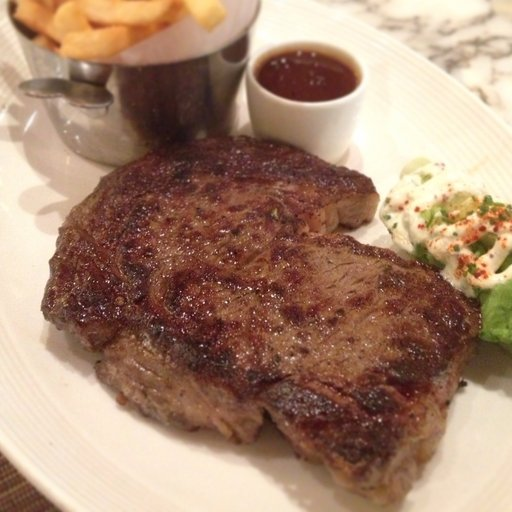

In [6]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all image paths
image_path_list= list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path= random.choice(image_path_list)
print(random_image_path)

# 3. Get image class from path name( the image class is the name of the directory where the image us stored)
image_class= random_image_path.parent.stem
print(image_class)

# 4. Open image
img= Image.open(random_image_path)

# 5.Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img


(0.0, 1.0, 0.0, 1.0)

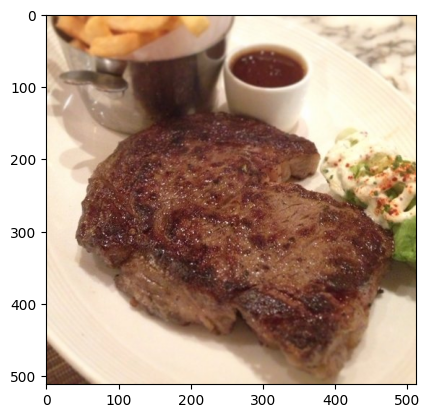

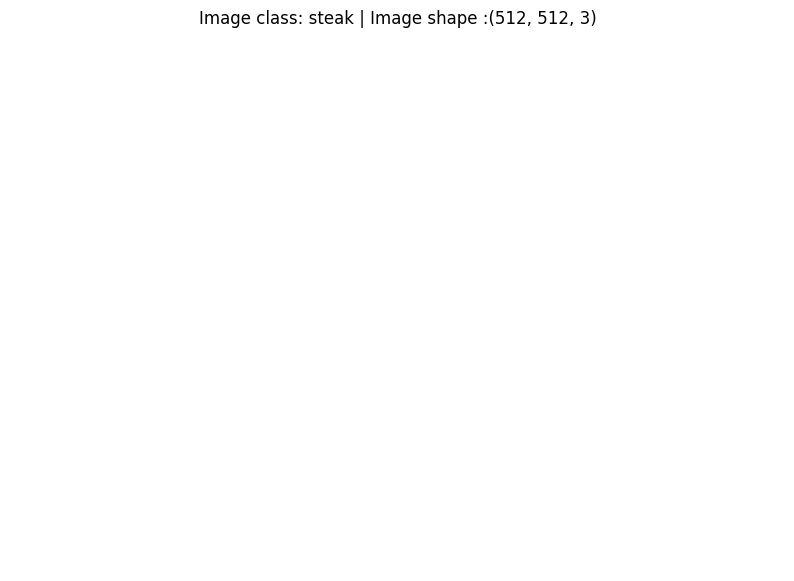

In [7]:
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(np.array(img))
plt.figure(figsize=(10,7))
plt.title(f"Image class: {image_class} | Image shape :{np.array(img).shape}")
plt.axis(False)

array([[[233, 215, 191],
        [231, 214, 188],
        [232, 215, 189],
        ...,
        [228, 208, 173],
        [228, 208, 173],
        [228, 208, 173]],

       [[232, 214, 190],
        [229, 212, 186],
        [229, 212, 186],
        ...,
        [229, 209, 174],
        [229, 209, 174],
        [229, 209, 174]],

       [[233, 213, 189],
        [229, 209, 184],
        [228, 208, 183],
        ...,
        [233, 211, 174],
        [233, 211, 174],
        [233, 211, 174]],

       ...,

       [[ 96,  69,  48],
        [101,  74,  53],
        [102,  74,  53],
        ...,
        [247, 227, 194],
        [248, 228, 195],
        [248, 228, 195]],

       [[ 88,  63,  41],
        [ 92,  67,  45],
        [ 94,  67,  46],
        ...,
        [247, 227, 194],
        [247, 227, 192],
        [247, 227, 192]],

       [[ 82,  57,  35],
        [ 84,  59,  37],
        [ 88,  61,  40],
        ...,
        [247, 227, 194],
        [247, 227, 192],
        [246, 226, 191]]], dtype=uint8)
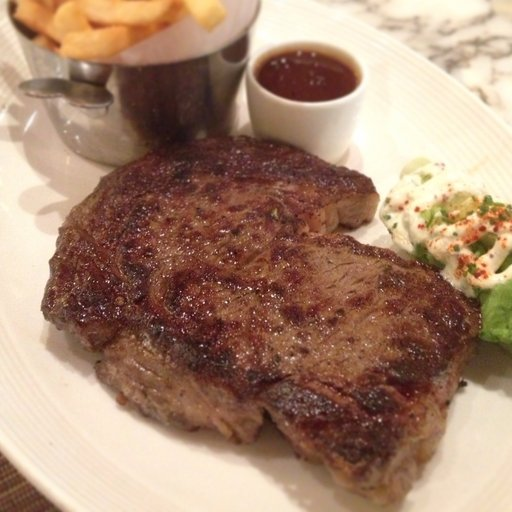

In [8]:
img_as_array= np.array(img)
img_as_array

## 3. Transforming Data

Before we can use our image data with pytorch:

1. Turn your target data into tensors ( in our case, numerical representation of out images
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader` , we'll call these `Datasets` and `DataLoader`.


In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


### 3.1 Transforming data with *torchvision.transform*

In [10]:
# Write a transform for image
data_transform= transforms.Compose([
                                    #Resize our image to 64 X 64]
                                    transforms.Resize(size=(64,64)),
                                    # Flip the image randomly on the horizontal
                                    transforms.RandomHorizontalFlip(p=0.5),
                                    # Turn the image into a torch tensor
                                    transforms.ToTensor()
                                    ])

In [11]:
data_transform(img).shape

torch.Size([3, 64, 64])

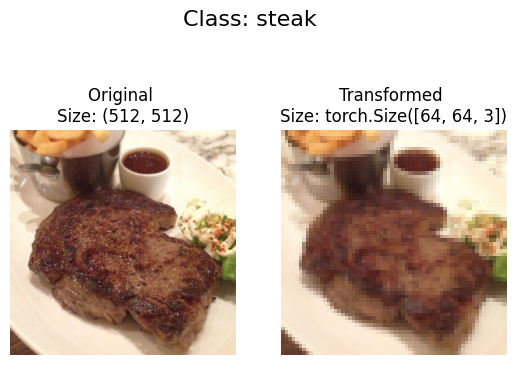

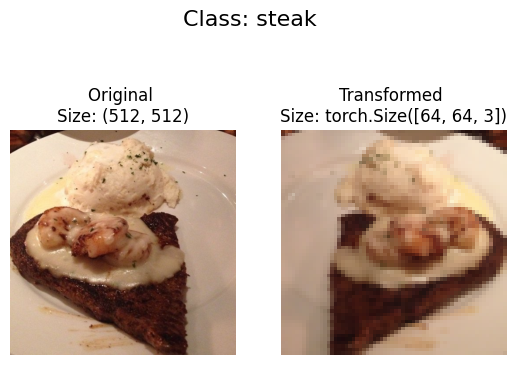

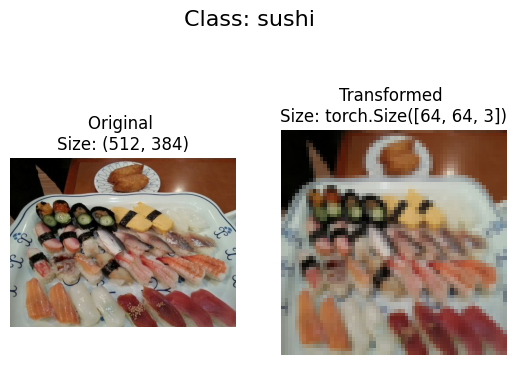

In [12]:
def plot_transformed_image(image_paths, transform, n=3, seed=None):
  ''' Select random images from a path of images and loads/transforms them then Plots original vs transformed images '''
  if seed:
    random.seed(seed)
  random_image_paths= random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax= plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image= transform(f).permute(1,2,0) # note we will need to change shape for matplotlib
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_image(image_paths=image_path_list,
                       transform=data_transform,
                       n=3,
                       seed=42)


## 4. Option 1. Loading image data using image folder

We can load image classification data using `torchvision.datasets.ImageFolder`

In [13]:
# Use Imagefolder to create datasets
from torchvision import datasets

train_data= datasets.ImageFolder(root= train_dir,
                                 transform= data_transform,   # A transform for the data
                                 target_transform= None # A transform for the label/target
                                 )
test_data= datasets.ImageFolder(root= test_dir,
                                transform= data_transform
                                )
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [14]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [15]:
# Get class name as list
class_names= train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [16]:
# Get class names as dict
class_dict= train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [17]:
# Check the lengths of our datset
len(train_data), len(test_data)

(225, 75)

In [18]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [19]:
# Index on the train_data Dataset to get a single image and label
img, label= train_data[0][0], train_data[0][1]
print(f"Image tensor: \n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datastype: {type(label)}")

Image tensor: 
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

In [20]:
class_names[label]

'pizza'

Original image shape: torch.Size([3, 64, 64]) -> [color channel, height, width]
Image permuted/reshaped shape: torch.Size([64, 64, 3]) -> [height, width, color channel]


(-0.5, 63.5, 63.5, -0.5)

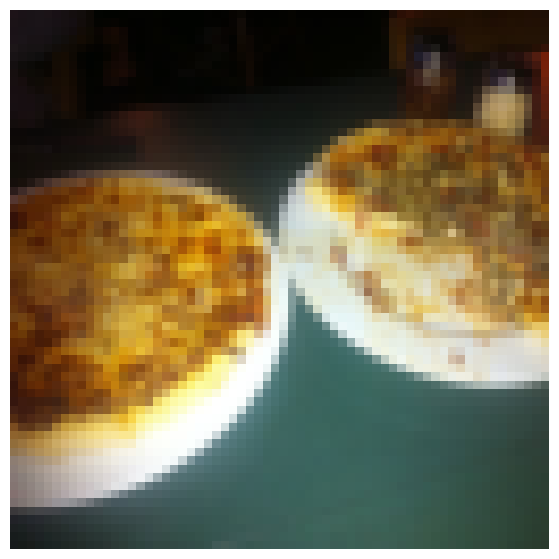

In [21]:
# Rearrange the order of dimensions
img_permute= img.permute(1,2,0)

# Print out different shapes
print(f"Original image shape: {img.shape} -> [color channel, height, width]")
print(f"Image permuted/reshaped shape: {img_permute.shape} -> [height, width, color channel]")

# Plot the reshaped image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis(False)

## 4.1 Turn loaded imagesinto `DataLoader`'s

A `DataLoder` is going to help us turn our Dataset into iterables and we can custmize the batch_size so our model can bee batch_size images at a time

In [22]:
# Turn train and test datasets into Dataloader's
from torch.utils.data import DataLoader
BATCH_SIZE=1

train_dataloader= DataLoader(dataset= train_data,
                             batch_size=BATCH_SIZE ,
                             num_workers=1,
                             shuffle=True,
                             )
test_dataloader= DataLoader(dataset= test_data,
                            batch_size= BATCH_SIZE,
                            num_workers=1,
                            shuffle=False,
                            )
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7bb6bb0023b0>,
 <torch.utils.data.dataloader.DataLoader at 0x7bb6bb003ac0>)

In [23]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [24]:
img, label= next(iter(train_dataloader))
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, weidth]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, weidth]
Label shape: torch.Size([1])


## 5. Option 2: Loading Image Data with a Custom `Dataset`.

1. Want to able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset


Pros:
* Can create a `Dataset` out of almost anything
* Not limited to pytorch pre-built `Dataset` funtions

Cons:
* Even though we could create `dataset` out of almost anything, it doesn't mean it will work
* Using a custom dataset often results in us writing more code, which could be prone to errors or performance issues

All custom dataset in pytorch, often subclass this


In [25]:
import os
import pathlib
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List


In [26]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get classs names

We want a function to :
1. Get the class names using `os.scandir()` to traverse a target directory (idenlly the directory is in standard image classification format).
2. Raise an error if the class names are not found( if this happens, there might be something wrong with the directory structure)
3. Turn the class names into a python list

In [27]:
# Setup path for target directory
target_directory= train_dir
print(f"Target directory: {target_directory}")

# Get class names as a list
class_names_found= [entry.name.split("/")[-1] for entry in os.scandir(target_directory) if entry.is_dir()]
class_names_found


Target directory: data/pizza_steak_sushi/train


['steak', 'sushi', 'pizza']

In [28]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  '''Finds the class folder names in a target directory'''

  # 1. Get the class names by scanning the target directory
  classes= sorted(entry.name.split("/")[-1] for entry in os.scandir(directory) if entry.is_dir())
  # 2. Raise an error if classs names couldnot be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}. Did you misspell the path?")

  # 3. Creata a dictonary of index labels (computers perfer numbers rather than string as labels)
  class_to_idx= {cls_name: i for i, cls_name in enumerate(classes)}

  return classes, class_to_idx


In [29]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

from ast import Attribute
### 5.2 Creating a custom `Dataset` To replicate `ImageFolder`

To create our own custom dataset, we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory ( the dict we'd like to get data from) as well as transform if we'd like to trasnform our data.
3. Create several Attribute for paths (the paths of our target images), transform (the transforms we might like to use, this can be None), classes and class_to_idx (from our find_classes() function).
4. Create a function to load images from file and return them, this could be using PIL or torchvision.io (for input/output of vision data).
5. Overwrite the __len__ method of torch.utils.data.Dataset to return the number of samples in the Dataset, this is recommended but not required. This is so you can call len(Dataset).
6. Overwrite the __getitem__ method of torch.utils.data.Dataset to return a single sample from the Dataset, this is required.

In [30]:
# Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize our custom dataset
  def __init__(self, targ_dir:str, transform= None):
    #3 Create class attributes
    # Get all of the image paths
    self.paths= list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # Setup transforms
    self.transform= transform
    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx= find_classes(targ_dir)

  # 4. Create a function to load images
  def load_image(self, index: int) -> Image.Image:
    "Opens and returns image at index"
    image_path= self.paths[index]
    return Image.open(image_path)

  # 5. Overwite __len__()
  def __len__(self):
    return len(self.paths)

  # 6. Overwrite __getitem__() method to return particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    image= self.load_image(index)
    class_name= self.paths[index].parent.name
    class_idx= self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(image), class_idx
    else:
      return image, class_idx


In [31]:
img, label= train_data[0]
img,label

(tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
          [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
          [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
          ...,
          [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
          [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
          [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],
 
         [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
          [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
          [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
          ...,
          [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
          [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
          [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],
 
         [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
          [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
          [0.0902, 0.0902, 0.0902,  ...,

In [32]:
# Create a transform
from torchvision.transforms import transforms
train_transfroms= transforms.Compose([
                                       transforms.Resize(size=(64,64)),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.ToTensor()
])

test_transforms= transforms.Compose([
                                      transforms.Resize(size=(64,64)),
                                      transforms.ToTensor()
])

In [33]:
# Test now ImageFolderCustom
train_data_custom= ImageFolderCustom(targ_dir= train_dir, transform= train_transfroms)
test_data_custom= ImageFolderCustom(targ_dir= test_dir, transform= test_transforms)

In [34]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7bb6baddfa00>,
 <__main__.ImageFolderCustom at 0x7bb6baddff70>)

In [35]:
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True


### 5.3 Create a function to display random images

1. Take in a `Dataset` and number of other parameters such as class names and how many images to vusualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproductivity
4. Get a list of sample indexes from the target dataset.
5. Setup a matplotlib plot.
6. Loop through the random sample images and plot them with matlpotlib
7. Make sure the dimensions of our images line up with matplotlib(HWC)



In [36]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str]=None,
                          n: int=10,
                          display_shape: bool=True,
                          seed: int=None,
                          ):
  #2. Adjust display if n is too high
  if n>10:
    n=10
    display_shape= False
    print(f"For display, purpose , n shouldnot be larger than 10")

  # 3. Set random seed
  if seed:
    random.seed(seed)

  # 4. Get random samples indexes
  random_samples_idx= random.sample(range(len(dataset)), k=n)

  #5. Setup plot
  plt.figure(figsize=(16,8))
  plt.subplots_adjust(hspace=0.5)

  #6. Loop through random indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label= dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust tensor dimensions for plotting
    targ_image_adjust= targ_image.permute(1,2,0)  # [color_channels, height, width] -> [heigth, width, color_channel]

    # Plot ajusted samples
    plt.subplot(1,n,i+1)
    plt.imshow(targ_image_adjust)
    if classes:
      title= (f"Class: {classes[targ_label]}")
      if display_shape:
        title+= f"\n Shape: {targ_image_adjust.shape}"
    plt.title(title)



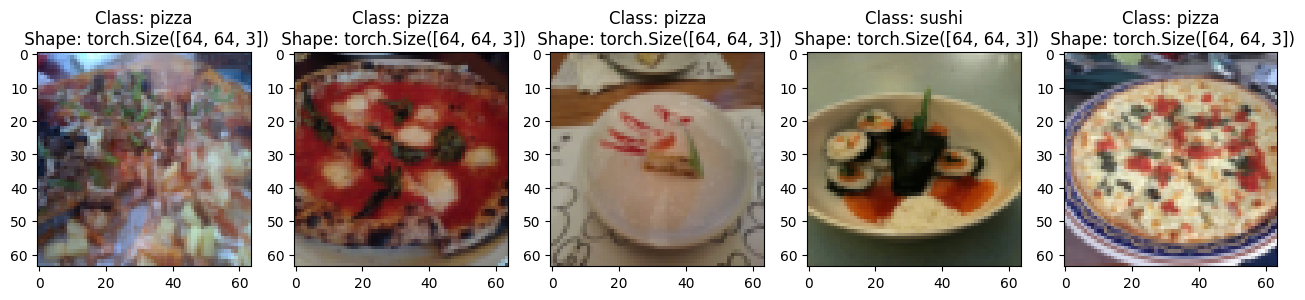

In [37]:
# Display random images from the ImageFolder created Dataset
display_random_images(dataset=train_data, classes=train_data.classes, n=5)

For display, purpose , n shouldnot be larger than 10


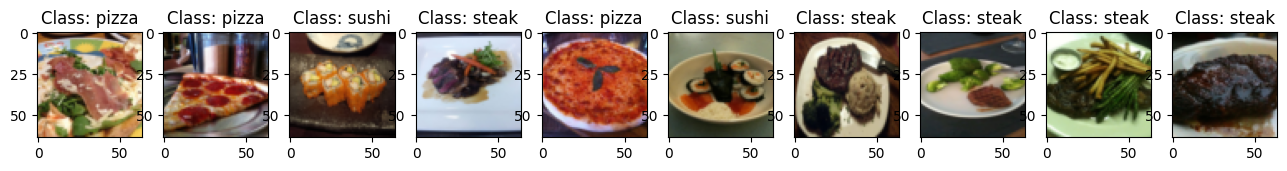

In [38]:
# Display random images from the ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=20,
                      classes= class_names,
                      seed= None)

### 5.4 Turn custom Loaded images into Dataloader's

In [39]:
from torch.utils.data import DataLoader
BATCH_SIZE=1
NUM_WORKERS=0
train_dataloader_custom= DataLoader(dataset= train_data_custom,
                                    batch_size= BATCH_SIZE,
                                    num_workers=NUM_WORKERS,  #how many h/w our computer to use for loading data
                                    shuffle=True)
test_dataloader_custom= DataLoader(dataset= test_data_custom,
                                   batch_size= BATCH_SIZE,
                                   num_workers=NUM_WORKERS,
                                   shuffle=False)
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7bb6b99d17b0>,
 <torch.utils.data.dataloader.DataLoader at 0x7bb6b99d08b0>)

In [40]:
# Get image and label from custom dataloader
img_custom, label_custom= next(iter(train_dataloader_custom))
print(f"Image shape: {img_custom.shape}")
print(f"Label shape: {label_custom.shape}")


Image shape: torch.Size([1, 3, 64, 64])
Label shape: torch.Size([1])


## 6. Other form of transform

Data agumentation is the process of artifically adding diversity to our training data.

In case of image data, this may mean applying various image transformations to the training images.

This practice hopefully results in a model that is more generalizable to unseen data.

Lets take a look at one particular type of data agumentation used to train Pytorch vision models to state of the art levels.






In [41]:
# Lets look at trivailaugment
from torchvision import transforms

train_transform= transforms.Compose([
                                    transforms.Resize(size=(224,224)),
                                    transforms.TrivialAugmentWide(num_magnitude_bins=5),  # how much transform to do
                                    transforms.ToTensor()
])

test_transform= transforms.Compose([
                                    transforms.Resize(size=(224,224)),
                                    transforms.ToTensor()
])

In [42]:
# Get all the image paths
image_path_list= list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/train/steak/1976160.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2614189.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/225990.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/355715.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/482022.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/167069.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/3142674.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1225762.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1264154.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/165639.jpg')]

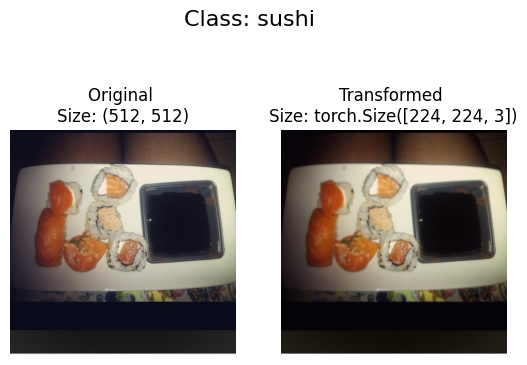

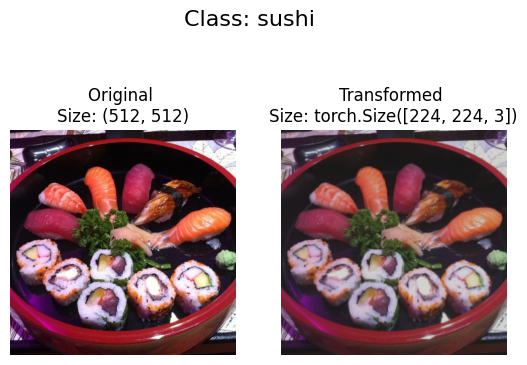

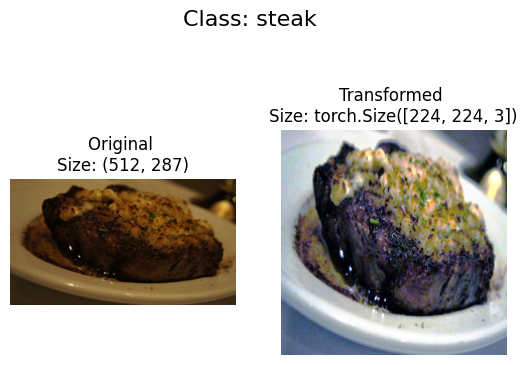

In [43]:
# Plot random transformed images
plot_transformed_image(
    image_paths=image_path_list,
    transform= train_transform,
    n=3,
    seed=None
)

## 7. Model 0: TinyVGG without data agumentation

Lets replication from TinyVGG architecture from CNN explainer website


### 7.1 Creating transform and loading data for MOdel 0


In [44]:
# Create simple transform
simple_transform= transforms.Compose([transforms.Resize(size=(64,64)),
                                      transforms.ToTensor()
                                      ])


In [45]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple= datasets.ImageFolder(root= train_dir,
                                        transform= simple_transform
                                        )

test_data_simple= datasets.ImageFolder(root= test_dir,
                                        transform= simple_transform
                                        )

# 2. Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of works
BATCH_SIZE= 32
NUM_WORKERS= os.cpu_count()

# Create DataLoader's
train_dataloader_simple= DataLoader(dataset=train_data_simple,
                                    batch_size= BATCH_SIZE,
                                    shuffle= True,
                                    num_workers= NUM_WORKERS
                                    )

test_dataloader_simple= DataLoader(dataset=test_data_simple,
                                    batch_size= BATCH_SIZE,
                                    shuffle= False,
                                    num_workers= NUM_WORKERS
                                    )


### 7.2 Create tinyVGG class

In [46]:
class TinyVGG(nn.Module):

  ''' MOdel architectute is copying TinyVgg from CNN explainer website
  '''

  def __init__(self,input_shape:int,
               hidden_unit:int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block1= nn.Sequential(
        nn.Conv2d(in_channels= input_shape,
                  out_channels= hidden_unit,
                  kernel_size=3,
                  stride=1,
                  padding=0
                  ),
        nn.ReLU(),
        nn.Conv2d(in_channels= hidden_unit,
                  out_channels= hidden_unit,
                  kernel_size=3,
                  stride=1,
                  padding=0
                  ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default value is same as kernel_size


    )
    self.conv_block2= nn.Sequential(
        nn.Conv2d(in_channels= hidden_unit,
                  out_channels= hidden_unit,
                  kernel_size=3,
                  stride=1,
                  padding=0
                  ),
        nn.ReLU(),
        nn.Conv2d(in_channels= hidden_unit,
                  out_channels= hidden_unit,
                  kernel_size=3,
                  stride=1,
                  padding=0
                  ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
     ) # default value is same as kernel_size



    self.classifier= nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features= hidden_unit*13*13, # image size is of 64*64 so after flatten layer its input become 10*64/4*64/4  here when padding is removed the the dimension also changes
                  out_features= output_shape
                  )
    )

  def forward(self, x):
    x= self.conv_block1(x)
    # print(x.shape)
    x= self.conv_block2(x)
    # print(x.shape)
    x= self.classifier(x)
    # print(x.shape)

    return x

In [47]:
torch.manual_seed(42)
model_0= TinyVGG(input_shape=3,
                 hidden_unit=10,
                 output_shape=len(train_data_simple.classes)
                 )
model_0

TinyVGG(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image(to test the model)


In [48]:
# Get a single image batch
image_batch, label_batch= next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [49]:
# Try a forward pass
model_0(image_batch)

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4668e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9131e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6415e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.1665e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

In [50]:
pip install torchinfo

In [51]:
from torchinfo import summary

summary(model_0, input_size=(32,3,64,64))


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

## 7.5 Create train and test loops functions

* `train_step()`- Takes in a model and dataloader and trains the model on the dataloader
* `test_step()` -  Takes in a model and dataloader and tests the model on the dataloader


In [52]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loos_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):

  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc= 0,0

  # Loop through data loader data batches
  for batch, (X,y) in enumerate(dataloader):
    # Send the data to target device
    X, y= X.to(device), y.to(device)

    # 1. Forward pass
    y_pred= model(X) # Output model logits

    # Calculate the loss
    loss= loss_fn(y_pred, y)
    train_loss+= loss.item()

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # Optimizer step
    optimizer.step()

    # Calculate the accuracy matric
    y_pred_class= torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc+= (y_pred_class==y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss= train_loss/len(dataloader)
  train_acc= train_acc/len(dataloader)
  return train_loss, train_acc

In [53]:
# Create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):
  model.eval()
  test_loss, test_acc= 0,0
  with torch.inference_mode():
    for batch, (X,y) in enumerate(dataloader):
      # Loop through DataLoader batches
      X, y= X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits= model(X)

      # Calculate the loss
      loss= loss_fn(test_pred_logits, y)
      test_loss+= loss.item()

      # Calculate the accuracy
      test_pred_labels= test_pred_logits.argmax(dim=1)
      test_acc+= ((test_pred_labels==y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss= test_loss/len(dataloader)
  test_acc= test_acc/len(dataloader)
  return test_loss, test_acc


### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`

In [54]:
from tqdm.auto import tqdm

# 1 Create a train funtion that take in various model parameters + optimizer + datatloader
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module= nn.CrossEntropyLoss(),
          epochs: int=5,
          device= device
          ):

  # 2. Create a empty result dictonary
  results= {"train_loss": [],
            "train_acc": [],
            "test_loss": [],
            "test_acc": []
            }

  # 3. Loop through training and testing steps for a number of epochs
  for epochs in tqdm(range(epochs)):
    train_loss, train_acc= train_step(model, train_dataloader, loss_fn, optimizer, device)
    test_loss, test_acc= test_step(model, test_dataloader, loss_fn, device)

    # 4 Print out whats happening
    print(f"Epochs: {epochs+1} | Train_loss: {train_loss:.4f} | Train_acc: {train_acc:.4f} | Test_loss: {test_loss:.4f} | Test_acc: {test_acc:.4f}")

    # 5. Update the results dictionary
    results['train_loss'].append(train_loss)
    results['train_acc'].append(train_acc)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)

  # 6 Retun the filled results at the end of the epochs
  return results


### 7.7 Train the model and evaluate model_0

In [55]:
# Ste the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0= TinyVGG(input_shape= 3,
                 hidden_unit=10,
                 output_shape= len(train_data.classes)
                 )

# set loss function and optimizer
loss_fn= nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(params= model_0.parameters(),
                            lr= 0.001)

# Start the timer
from timeit import default_timer as timer
start_time= timer()

# Train model_0
model_0_results= train(model= model_0,
                       train_dataloader= train_dataloader_simple,
                       test_dataloader= test_dataloader_simple,
                       optimizer= optimizer,
                       loss_fn= loss_fn,
                       epochs= NUM_EPOCHS,
                       device= device
                       )

# End the timer and print out how long it took
end_timer= timer()
print(f"Total training time: {end_timer-start_time:.3f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

Epochs: 1 | Train_loss: 1.1063 | Train_acc: 0.3047 | Test_loss: 1.0983 | Test_acc: 0.3011
Epochs: 2 | Train_loss: 1.0998 | Train_acc: 0.3281 | Test_loss: 1.0697 | Test_acc: 0.5417
Epochs: 3 | Train_loss: 1.0869 | Train_acc: 0.4883 | Test_loss: 1.0808 | Test_acc: 0.4924
Epochs: 4 | Train_loss: 1.0842 | Train_acc: 0.3984 | Test_loss: 1.0608 | Test_acc: 0.5833
Epochs: 5 | Train_loss: 1.0662 | Train_acc: 0.4141 | Test_loss: 1.0654 | Test_acc: 0.5644
Total training time: 17.407 seconds


In [56]:
model_0_results

{'train_loss': [1.106319084763527,
  1.0998057276010513,
  1.0868544578552246,
  1.0842333287000656,
  1.0662163645029068],
 'train_acc': [0.3046875, 0.328125, 0.48828125, 0.3984375, 0.4140625],
 'test_loss': [1.0983205238978069,
  1.069690187772115,
  1.0807572205861409,
  1.0608318249384563,
  1.0653960307439168],
 'test_acc': [0.30113636363636365,
  0.5416666666666666,
  0.49242424242424243,
  0.5833333333333334,
  0.5643939393939394]}

### 7.8 Plot the loss cure of the model_0

Loss curve is the progress curve of our model during the training.



In [57]:
# Get the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [58]:
def plot_loss_curves(results):
  """Plots training curves of a results dictionary."""

  # Get the loss values of the training and test
  loss= results['train_loss']
  test_loss= results['test_loss']

  # Get the accuracy values of the results dictionary (training and test)
  accuracy= results['train_acc']
  test_accuracy= results['test_acc']

  # figure out how many epochs there were
  epochs= range(len(results['train_loss']))

  #Setup a plot
  plt.figure(figsize=(15,7))

  # Plot the loss
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label= 'train_loss')
  plt.plot(epochs, test_loss, label= 'test_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # plot the accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label= 'train_accuracy')
  plt.plot(epochs, test_accuracy, label= 'test_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

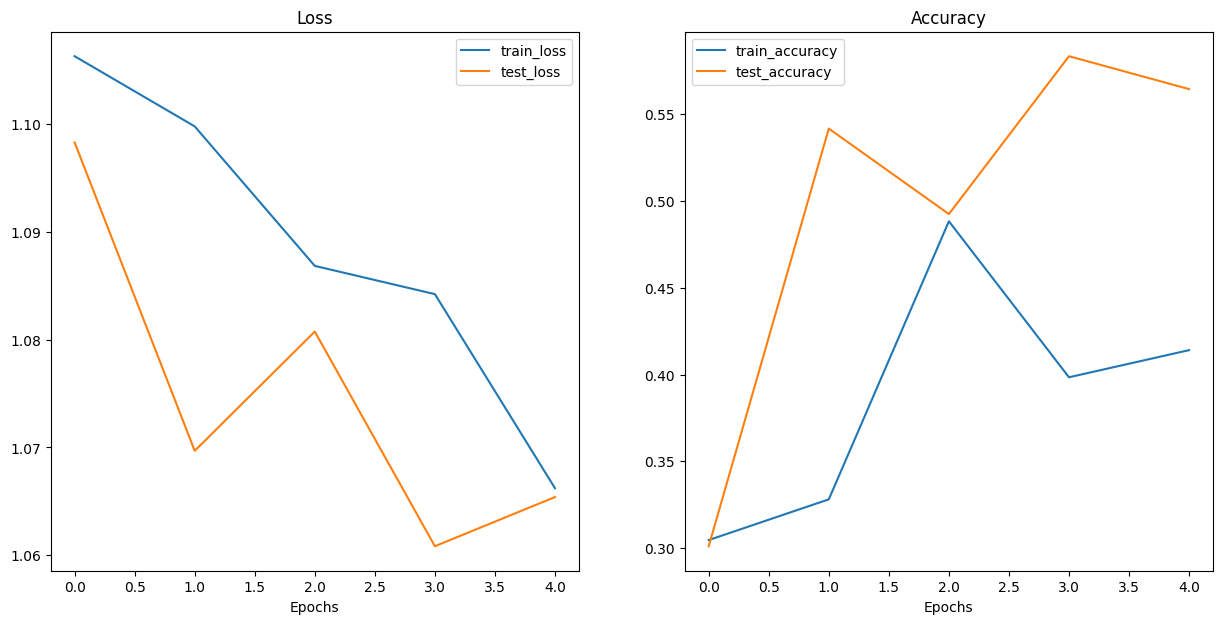

In [59]:
plot_loss_curves(model_0_results)

## 8. What should an ideal loss curve look like?

A loss curve is one of the most helpful ways tp trobuleshoot the

## 9. Model 1 : TInyVGG with Data Augumentation

Now lets try another modeling experiment this time using the same model as before with some data augumentation.

### 9.1 Create transform with data agumentation

In [60]:
# Create training transform with TrivialAgument
from torchvision import transforms
train_trainform_trivial= transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transforms_simple= transforms.Compose([transforms.Resize(size=(64,64)),
                                            transforms.ToTensor()
                                            ])


### 9.2 Create a train and test Datasets and Dataloader with data agumentation

In [61]:
# Turn image folders intp Datasets
from torchvision import datasets
train_data_agumented= datasets.ImageFolder(root= train_dir,
                                           transform=train_trainform_trivial
                                           )
test_data_simple= datasets.ImageFolder(root= test_dir,
                                       transform=test_transforms_simple)

In [62]:
# Turn our Dataset into DataLoaders
import os
from torch.utils.data import DataLoader

#Set up batch size and numworkers
BATCH_SIZE= 32
NUM_WORKERS= os.cpu_count()

torch.manual_seed(42)
train_dataloader_agumented= DataLoader(dataset= train_data_agumented,
                                       batch_size= BATCH_SIZE,
                                       shuffle= True,
                                       num_workers= NUM_WORKERS)

test_dataloader_simple= DataLoader(dataset= test_data_simple,
                                   batch_size= BATCH_SIZE,
                                   shuffle= False,
                                   num_workers= NUM_WORKERS)

### 9.3 Construct and train model

This time we'll be using the same model architecture except this time we'll train it with data agumentation.

In [63]:
# Create model_1 and send it to the target model
torch.manual_seed(42)
model_1= TinyVGG(input_shape=3,
                 hidden_unit=10,
                 output_shape= len(train_data_agumented.classes)
                 ).to(device)

In [64]:
model_1

TinyVGG(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

Now we have a model and dataloader, lets create a loss function and an optimizer and call upon our evaluate our model

In [65]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#Set the numner of epochs
NUM_EPOCHS= 5

#Set loss function
loss_fn= nn.CrossEntropyLoss()

#Set optimizer
optimizer= torch.optim.Adam(params= model_1.parameters(),
                            lr= 0.001)

#Start the timer
from timeit import default_timer as timer
start_time= timer()

#Train model_1
model_1_results= train(model= model_1,
                       train_dataloader= train_dataloader_agumented,
                       test_dataloader= test_dataloader_simple,
                       optimizer= optimizer,
                       loss_fn= loss_fn,
                       epochs= NUM_EPOCHS,
                       device= device
                       )
# End the timer
end_time= timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epochs: 1 | Train_loss: 1.1049 | Train_acc: 0.2500 | Test_loss: 1.1019 | Test_acc: 0.2604
Epochs: 2 | Train_loss: 1.0807 | Train_acc: 0.4258 | Test_loss: 1.1261 | Test_acc: 0.2604
Epochs: 3 | Train_loss: 1.0712 | Train_acc: 0.4258 | Test_loss: 1.1593 | Test_acc: 0.2604
Epochs: 4 | Train_loss: 1.1253 | Train_acc: 0.3047 | Test_loss: 1.1581 | Test_acc: 0.2604
Epochs: 5 | Train_loss: 1.0865 | Train_acc: 0.4258 | Test_loss: 1.1554 | Test_acc: 0.3333
Total training time: 13.265 seconds


In [66]:
model_1_results

{'train_loss': [1.104914203286171,
  1.0806865319609642,
  1.0711720064282417,
  1.125308334827423,
  1.0865339040756226],
 'train_acc': [0.25, 0.42578125, 0.42578125, 0.3046875, 0.42578125],
 'test_loss': [1.1019279559453328,
  1.1260557969411213,
  1.159274657567342,
  1.1580672065416973,
  1.1554409265518188],
 'test_acc': [0.2604166666666667,
  0.2604166666666667,
  0.2604166666666667,
  0.2604166666666667,
  0.3333333333333333]}

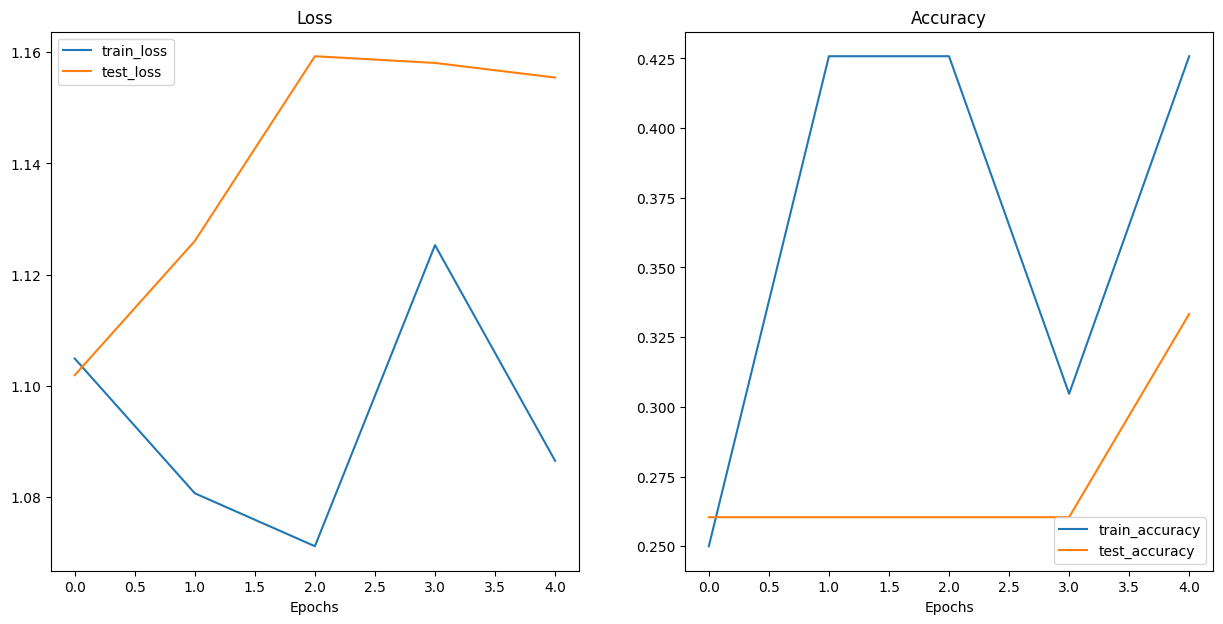

In [67]:
plot_loss_curves(model_1_results)

## 10. Compare model results

After evaluating our modelling experiments on their own, its important to compare them to each other.

There's a few difftent ways to do this:
1. Hardcoding ( what we are doing)
2. Pytorch + Tensorboard
3. Weights and bias
4. MLflow

In [68]:
import pandas as pd
model_0_df= pd.DataFrame(model_0_results)
model_1_df= pd.DataFrame(model_1_results)
model_0_df

train_loss  train_acc  test_loss  test_acc
0    1.106319   0.304688   1.098321  0.301136
1    1.099806   0.328125   1.069690  0.541667
2    1.086854   0.488281   1.080757  0.492424
3    1.084233   0.398438   1.060832  0.583333
4    1.066216   0.414062   1.065396  0.564394

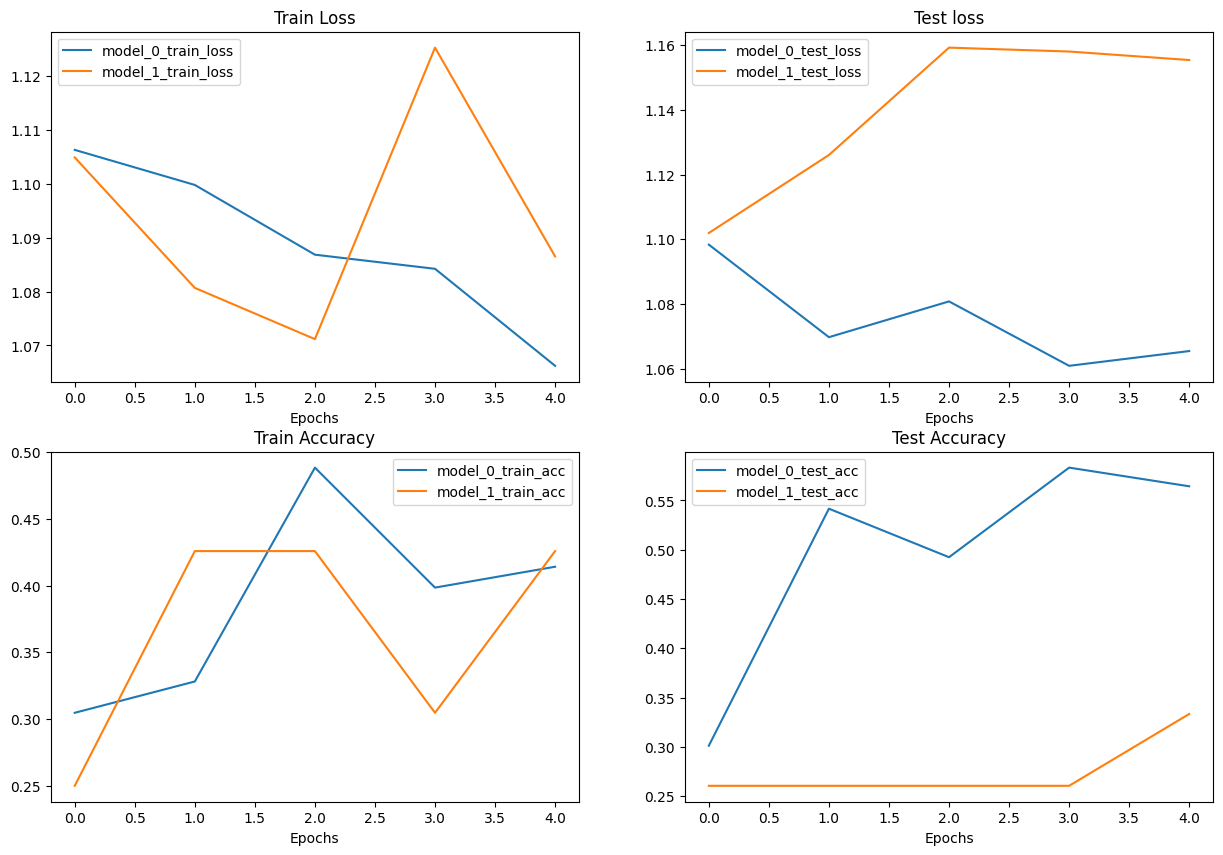

In [69]:
# Setup a plot
plt.figure(figsize= (15,10))

# Get number of epochs
epochs= range(len(model_0_df))

# Plot train loss
plt.subplot(2,2,1)
plt.plot(epochs, model_0_df['train_loss'], label= 'model_0_train_loss')
plt.plot(epochs, model_1_df['train_loss'], label= 'model_1_train_loss')
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot test loss
plt.subplot(2,2,2)
plt.plot(epochs, model_0_df['test_loss'], label= 'model_0_test_loss')
plt.plot(epochs, model_1_df['test_loss'], label= 'model_1_test_loss')
plt.title('Test loss')
plt.xlabel('Epochs')
plt.legend()

# Plot train Accuracy
plt.subplot(2,2,3)
plt.plot(epochs, model_0_df['train_acc'], label= 'model_0_train_acc')
plt.plot(epochs, model_1_df['train_acc'], label= 'model_1_train_acc')
plt.title('Train Accuracy')
plt.xlabel('Epochs')
plt.legend()


# Plot test Accuracy
plt.subplot(2,2,4)
plt.plot(epochs, model_0_df['test_acc'], label= 'model_0_test_acc')
plt.plot(epochs, model_1_df['test_acc'], label= 'model_1_test_acc')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.legend()



In [70]:
import numpy as np
arry= np.linspace(10,15,10)
arry

array([10.        , 10.55555556, 11.11111111, 11.66666667, 12.22222222,
       12.77777778, 13.33333333, 13.88888889, 14.44444444, 15.        ])

In [71]:
arry1= np.array([[[1,2],[3,4],[5,6]]])

arry1,arry1.shape


(array([[[1, 2],
         [3, 4],
         [5, 6]]]),
 (1, 3, 2))

In [72]:
arry1[0][1][1]

4

In [73]:
arry1.ndim, arry1.size, arry1.shape,arry1.itemsize

(3, 6, (1, 3, 2), 8)

## Making a prediction on a custom image

Although we've trained a model on custom data... how do we make a prediction on a sample/image that's not in our
 dataset

In [75]:
# Download custom image
import requests

# Setup custom image path
custom_image_path= data_path/ "04-pizza-dad.jpeg"

# Download the image if it doesnot already exits
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    # when downloading from github. need to use the raw file link
    request= requests.get('https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/04-pizza-dad.jpeg')
    print(f"Downloading {custom_image_path}....")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists")

data/04-pizza-dad.jpeg already exists


### 11.1 Loading in a custom image with pytorch

We have to make sure our custom image is in the same format as the data our model was trained on.

* In tensor form with datatype(torch.float32)
* Of shape 64 X 64 X 3
* On the right device



In [91]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

In [92]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

# Print out image data
print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 4032, 3024])

Custom image dty

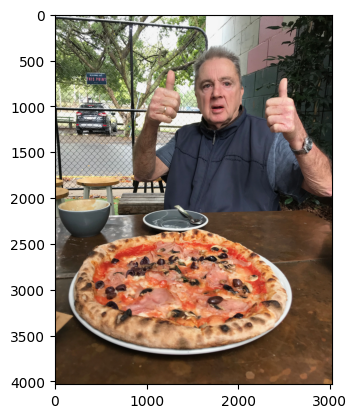

In [96]:
plt.imshow(custom_image_uint8.permute(1,2,0))

In [107]:
import torchvision.transforms as transforms
import torch
from PIL import Image

image= Image.open(custom_image_path)

resize_transform= transforms.Resize(size=(64,64))
image_resize= resize_transform(image)
image_resize_tensor= transforms.ToTensor()(image_resize)
image_resize_tensor.shape

image_resize_tensor

tensor([[[0.4667, 0.5294, 0.5608,  ..., 0.0980, 0.0588, 0.0588],
         [0.4000, 0.4353, 0.4275,  ..., 0.0667, 0.0706, 0.0863],
         [0.5176, 0.4863, 0.4471,  ..., 0.0627, 0.0588, 0.0706],
         ...,
         [0.2980, 0.2824, 0.2706,  ..., 0.4588, 0.4000, 0.3961],
         [0.2784, 0.2706, 0.2588,  ..., 0.4627, 0.4196, 0.3765],
         [0.2510, 0.2549, 0.2706,  ..., 0.4902, 0.6078, 0.5333]],

        [[0.4941, 0.5529, 0.5765,  ..., 0.1255, 0.0706, 0.0667],
         [0.4549, 0.4863, 0.4588,  ..., 0.0824, 0.0824, 0.1020],
         [0.5490, 0.5216, 0.4784,  ..., 0.0706, 0.0706, 0.0863],
         ...,
         [0.2078, 0.1961, 0.1882,  ..., 0.3137, 0.2784, 0.2784],
         [0.1922, 0.1882, 0.1804,  ..., 0.3216, 0.2941, 0.2667],
         [0.1725, 0.1765, 0.1882,  ..., 0.3412, 0.4235, 0.3686]],

        [[0.4510, 0.5255, 0.5608,  ..., 0.0824, 0.0392, 0.0431],
         [0.3137, 0.3608, 0.3843,  ..., 0.0510, 0.0549, 0.0784],
         [0.4784, 0.4235, 0.3961,  ..., 0.0471, 0.0471, 0.

### 11.2 Make a prediction on a custom imag with a trained Pytorch model


In [110]:
# Load in the custom image and convert to torch.float32
custom_image= torchvision.io.read_image(str(custom_image_path)).type(torch.float32)/255
custom_image, custom_image.shape

(tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
          [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
          [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
          ...,
          [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
          [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
          [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],
 
         [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
          [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
          [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
          ...,
          [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
          [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
          [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],
 
         [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
          [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
          [0.3412, 0.4353, 0.5333,  ...,

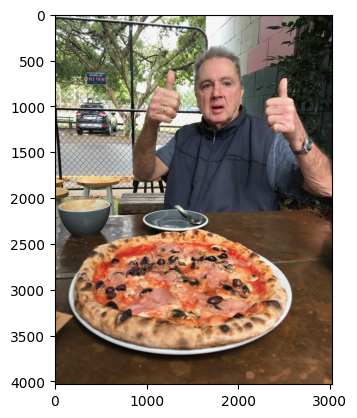

In [111]:
plt.imshow(custom_image.permute(1,2,0))

In [112]:
model_1.eval()
with torch.inference_mode():
  model_1(custom_image.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x7567650 and 1690x3)

In [113]:
# Create transform pipeline to resize image
from torchvision import transforms
custom_image_transforms= transforms.Compose([
    transforms.Resize(size=(64,64))
])
# Transform target image
custom_image_transformed= custom_image_transforms(custom_image)

# Print out the shape
print(f"Original shape: {custom_image.shape}")
print(f"Custom image shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
Custom image shape: torch.Size([3, 64, 64])


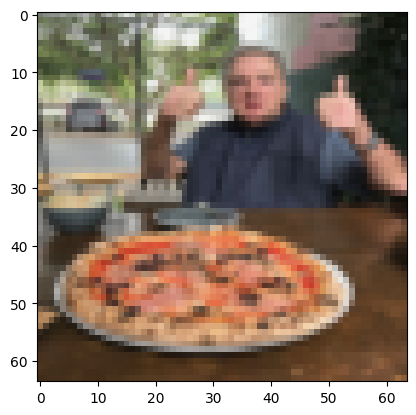

In [114]:
plt.imshow(custom_image_transformed.permute(1,2,0))

In [115]:
# this is error: no batch size
model_1.eval()
with torch.inference_mode():
  custom_image_pred= model_1(custom_image_transformed.to(device))
  print(f"Prediction on custom image: {custom_image_pred}")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x169 and 1690x3)

In [117]:
custom_image_transformed.shape, custom_image_transformed.unsqueeze(dim=0).shape

(torch.Size([3, 64, 64]), torch.Size([1, 3, 64, 64]))

In [119]:
model_1.eval()
with torch.inference_mode():
  custom_image_pred= model_1(custom_image_transformed.unsqueeze(dim=0).to(device))
  print(f"Prediction on custom image: {custom_image_pred}")

Prediction on custom image: tensor([[ 0.0781,  0.0379, -0.2067]])


Note to make a prediction on a custom image we had to:
* Load the image and turn into a tensor
* Make sure the image was the same datatype as the model (torch.float32)
* Make sure the image was the same shape as the data the model was trained on (3,64,64) with a batch size (1,3,64,64)
* Make sure the image was on the same device as our model

In [121]:
# Convert logits -> prediction probabilities
custom_image_pred_probs= torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs


tensor([[0.3686, 0.3541, 0.2773]])

In [122]:
# Covert predicition probabilitites -> prediction labels
custom_image_pred_labels= torch.argmax(custom_image_pred_probs, dim=1)
custom_image_pred_labels

tensor([0])

In [125]:
class_names[custom_image_pred_labels]

'pizza'

### 11.3 Putting custom image prediction together: building a function

Ideal outcome:

A function where we pass an image path to and have our model predict the class of the image


In [127]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: list[str],
                        transforms: None,
                        device= device
                        ):
  '''Makes a prediction on a target image with a trained model and plot the image and prediction.'''

  # Load in the image
  target_image= torchvision.io.read_image(str(image_path)).type(torch.float32)

  # Divide the image pixel valurs by 225 to get them between 0,1
  target_image= target_image/255

  # Transform the image
  if transforms:
    target_image= transforms(target_image)

  # Make sure the model is on target device
  model.to(device)

  # Ture on eval/inference mode and make a prediction
  model.eval()
  with torch.inference_mode():
    # Add the extra dimension to the image (this is the batch dimension, eg our model will predict on 1 image)
    target_image_pred= model(target_image.unsqueeze(dim=0).to(device))

  # Convert the logits -> prediction probabilities
  target_image_pred_probs= torch.softmax(target_image_pred, dim=1)

  # Convert prediciton probabilititws -> prediciton labels
  target_image_pred_labels= torch.argmax(target_image_pred_probs, dim=1)

  # Plot the image alongsize the prediction and prediction probability
  plt.imshow(target_image.permute(1,2,0))
  if class_names:
    title= f"Pred: {class_names[target_image_pred_labels]} | Prob: {target_image_pred_probs.max():.3f}"
  else:
    title= f" Pred: {target_image_pred_labels} | Prob: {target_image_pred_probs.max():.3f}"

  plt.title(title)
  plt.axis(False)

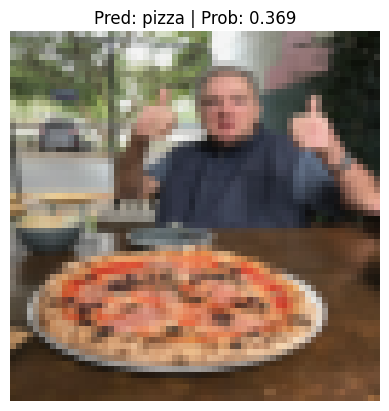

In [131]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names= class_names,
                    transforms= custom_image_transforms,
                    device= device
                    )